# Development of several src functions

## make_roms_ds

In [11]:
%%writefile ../src/features/roms_ds.py
#read in raw data as xr.dataset
import xarray as xr
import numpy as np
from .calc_z import calc_z

def make_roms_ds(file_paths):
    
    print('set up multifile dataset')
    ds_tmp = xr.open_mfdataset(file_paths)
    
    
    print('set up 4D mask and add as variable to dataset')
    mask_4d = np.swapaxes(np.tile(ds_tmp.mask_rho,(ds_tmp.s_rho.size,1,1,1)),0,1)
    mask_4d_da = xr.DataArray(mask_4d,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
    ds_tmp['mask_4d'] = mask_4d_da
    ds_tmp.mask_4d.attrs = ds_tmp.mask_rho.attrs
    
    
    print('set up 3D xi and eta arrays, mask them and apply as coordinates')
    xi_3d = np.tile(ds_tmp.xi_rho,(ds_tmp.s_rho.size,ds_tmp.eta_rho.size,1))
    eta_3d = np.swapaxes(np.tile(ds_tmp.eta_rho,(ds_tmp.s_rho.size,ds_tmp.xi_rho.size,1)),1,2)
    
    xi_3d_ma = np.ma.masked_where(mask_4d[0]==0,xi_3d)
    eta_3d_ma = np.ma.masked_where(mask_4d[0]==0,eta_3d)
    
    xi_3d_da = xr.DataArray(xi_3d_ma,dims=['s_rho','eta_rho','xi_rho'])
    eta_3d_da = xr.DataArray(eta_3d_ma,dims=['s_rho','eta_rho','xi_rho'])
    
    ds_tmp = ds_tmp.assign_coords(xi_3d=xi_3d_da)
    ds_tmp = ds_tmp.assign_coords(eta_3d=eta_3d_da)
    
    ds_tmp.xi_3d.attrs = ds_tmp.xi_rho.attrs
    ds_tmp.eta_3d.attrs = ds_tmp.eta_rho.attrs
    
    
    print('calculate 4D depth array')
    depths = np.empty((ds_tmp.ocean_time.size,ds_tmp.s_rho.size,ds_tmp.eta_rho.size,ds_tmp.xi_rho.size))
    
    for tstep in np.arange(ds_tmp.ocean_time.size):

        h = ds_tmp.h[tstep].values
        zice = ds_tmp.zice[tstep].values
        theta_s = ds_tmp.theta_s[tstep].values
        theta_b = ds_tmp.theta_b[tstep].values
        hc = ds_tmp.hc[tstep].values
        N = ds_tmp.s_rho.size
        zeta = ds_tmp.zeta[tstep].values
        Vstretching = ds_tmp.Vstretching[tstep].values
        depths[tstep],s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)
        
    print('apply mask to depths')
    depths_ma = np.ma.masked_where(ds_tmp.mask_4d==0,depths)
        
    print('assign depth as new coordinate to the data set')
    depth_da = xr.DataArray(depths_ma,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
    ds = ds_tmp.assign_coords(depth=depth_da)
    
    return ds

Overwriting ../src/features/roms_ds.py


### Build a test for make_roms_ds

In [22]:
%%writefile ../src/features/test_features.py

import os
import sys

# add the 'src/' directory as one where we can import modules
src_dir = os.path.join('src')
sys.path.append(src_dir)

def test_make_roms_ds():
    
    from features.roms_ds import make_roms_ds
    import os
    
    file_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_avg_000[4,5].nc')
    ds = make_roms_ds(file_path)
    
    assert ds.depth.isnull().any() == True, 'depth has no NaN'

Overwriting ../src/features/test_features.py


In [15]:
test_make_roms_ds()

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, mask them and apply as coordinates
calculate 4D depth array
apply mask to depths
assign depth as new coordinate to the data set


### Mask variables

It is not possible to store masked arrays in xarrays. workable solutions are to use da.to_masked_array(), da.isnull(), da.notnull(), ma.mask_invalid(ds.values) 
### Plotting examples

In [9]:
import sys
import os

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.pardir,'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
%aimport features.build_roms_ds

from features.roms_ds import make_roms_ds

file_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_avg_000[4,5].nc')

ds_tmp = make_roms_ds(file_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, mask them and apply as coordinates
calculate 4D depth array
apply mask to depths
assign depth as new coordinate to the data set


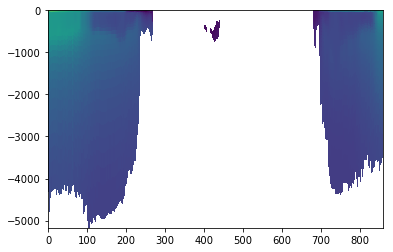

In [173]:
plt.clf()
#ds_tmp.temp[0,:,300,:].plot.pcolormesh(x='xi_3d',y='depth')
da = ds_tmp.temp[0,:,300]
val = da.to_masked_array()
x = da.xi_3d.to_masked_array()
y = da.depth.to_masked_array()
plt.pcolormesh(x,y,val)
plt.show()

## make_sose_ds

In [62]:
#import sose module and define sose_data path 
import os
import sys
import xarray as xr
# add the 'src/' directory as one where we can import modules
src_dir = os.path.join(os.pardir,'src')
sys.path.append(src_dir)

import features.mds as mds
import scipy.io as sio
import numpy as np

# add the 'src/visualization/' directory as one where we can import modules
sose_dir = os.path.join(os.pardir,'data','external','sose')

In [57]:
mds.rdmds?

In [58]:
sose_grid_path = os.path.join(sose_dir,'grid.mat')
sose_grid = sio.loadmat(sose_grid_path)

sose_temp_path = os.path.join(sose_dir,'THETA_mnthlyBar')
sose_temp_raw,itr,sose_temp_raw_meta = mds.rdmds(sose_temp_path,100,returnmeta=True,rec=0,fill_value=np.NaN)

/home/ubuntu/bigStick/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [78]:
lats=(('longitude','latitude'),sose_grid["XC"])
lons=sose_grid["YC"]
depths=sose_grid["Depth"]
sose_temp_da = xr.DataArray(sose_temp_raw,coords={'latitude':lats})

MissingDimensionsError: 'latitude' has more than 1-dimension and the same name as one of its dimensions ('longitude', 'latitude'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.

In [74]:
sose_grid.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Depth', 'DXC', 'DXG', 'DYC', 'DYG', 'hFacC', 'hFacS', 'hFacW', 'maskCtrlC', 'maskCtrlS', 'maskCtrlW', 'XC', 'XG', 'YC', 'YG', 'RAC', 'RAS', 'RAW', 'RAZ', 'RC', 'RF', 'DRC', 'DRF'])

In [70]:
sose_temp_da

<xarray.DataArray (depth: 42, latitude: 320, longitude: 2160)>
array([[[  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        ..., 
        [  2.264508e+01,   2.263531e+01, ...,   2.266486e+01,   2.265486e+01],
        [  2.261070e+01,   2.260002e+01, ...,   2.263203e+01,   2.262136e+01]],

       [[  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        ..., 
        [  2.258324e+01,   2.257294e+01, ...,   2.260341e+01,   2.259324e+01],
        [  2.253064e+01,   2.251884e+01, ...,   2.255422e+01,   2.254243e+01]],

       ..., 
       [[  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        [  0.000000e+00,   0.000000e+00, ...,   0.000000e+00,   0.000000e+00],
        ..., 
        [  1.961878e+00,   1.962632e+00, ...,   2.259535e-07,   0.000000e+00],
        [